
[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 14:49:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|      class|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



25/05/06 14:50:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression Accuracy: 1.0000
KMeans Cluster Centers:
[5.9016129  2.7483871  4.39354839 1.43387097]
[5.006 3.418 1.464 0.244]
[6.85       3.07368421 5.74210526 2.07105263]


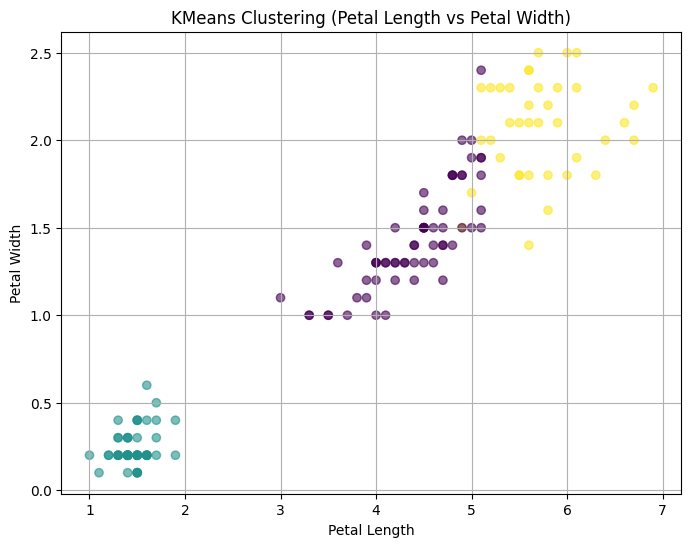

In [1]:
# Step 0: Install and import dependencies
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Initialize Spark session
spark = SparkSession.builder.appName("IrisClassificationClustering").getOrCreate()

# Step 2: Download and load the Iris dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
local_file = "iris.csv"
urllib.request.urlretrieve(url, local_file)

# Define column names
columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
df = spark.read.csv(local_file, inferSchema=True).toDF(*columns)

# Show first few records
df.show(5)

# Step 3: Data Preprocessing

# Convert class labels to numerical labels
indexer = StringIndexer(inputCol="class", outputCol="label")
df_indexed = indexer.fit(df).transform(df)

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"],
    outputCol="features"
)
df_features = assembler.transform(df_indexed).select("features", "label")

# Step 4: Classification using Logistic Regression

# Split data into training and testing sets
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# Train logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
lr_model = lr.fit(train_data)

# Evaluate logistic regression model
lr_predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Step 5: Clustering using KMeans

# Train KMeans model with 3 clusters (since there are 3 iris species)
kmeans = KMeans(featuresCol="features", k=3, seed=1)
kmeans_model = kmeans.fit(df_features)

# Predict cluster assignments
kmeans_predictions = kmeans_model.transform(df_features)

# Show cluster centers
print("KMeans Cluster Centers:")
for center in kmeans_model.clusterCenters():
    print(center)

# Step 6: Visualize Clustering Results

# Convert to Pandas for visualization
kmeans_pd = kmeans_predictions.select("features", "label", "prediction").toPandas()
features_array = kmeans_pd["features"].apply(lambda x: x.toArray())
features_df = pd.DataFrame(features_array.tolist(), columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
features_df["label"] = kmeans_pd["label"]
features_df["prediction"] = kmeans_pd["prediction"]

# Plot clustering results (petal length vs petal width)
plt.figure(figsize=(8, 6))
plt.scatter(features_df["petal_length"], features_df["petal_width"], c=features_df["prediction"], cmap='viridis', label="Clusters", alpha=0.6)
plt.title("KMeans Clustering (Petal Length vs Petal Width)")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.grid(True)
plt.show()
